In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from solution.feature_extraction import FeatureExtraction
from solution.prediction import (
    predict,
    get_threshold,
)

In [7]:
# Extract data for training. Same dataframe is saved inside resources/data.pkl
fe = FeatureExtraction(
    [
        "so-ids-2023.04.17",
        "so-ids-2023.04.13",
        "so-ids-2023.05.02",
        "so-ids-2023.05.05",
    ],
    4000,
)

# Parse logs
df = fe.parse_logs()

# Preprocess
df = fe.preprocess_dataframe(df)

In [4]:
df

,conn_length,conn_bytes_toserver,conn_bytes_toclient,http_body_length,file_size,dataset_conn,dataset_dhcp,dataset_dns,dataset_file,dataset_http,...,http_status_message_Found,http_status_message_No Content,http_status_message_Not Modified,http_status_message_OK,http_status_message_Temporary Redirect,http_status_message_UNK,file_source_UNK,file_source_http,ssh_client_OpenSSH_8.9p1,ssh_client_UNK
0,0.000000e+00,0.000009,0.000000,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,8.928232e-03,0.000156,0.000000,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
2,7.806565e-04,0.000542,0.000080,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,3.628222e-07,0.000011,0.000003,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,7.364788e-08,0.000010,0.000002,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58903,0.000000e+00,0.000000,0.000000,0.0,0.002617,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
58904,0.000000e+00,0.000000,0.000000,0.0,0.002744,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
58905,0.000000e+00,0.000000,0.000000,0.0,0.002471,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
58906,0.000000e+00,0.000000,0.000000,0.0,0.002598,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


In [89]:
from keras.layers import Input, Dense, concatenate, Dropout
from keras.models import Model

# Extract numerical and categorical features
input_layer = Input(shape=(139,))
numerical_inputs = input_layer[:, :5]
categorical_inputs = input_layer[:, 5:]

# Encoding layers for numerical inputs
encoded_num = Dense(3, activation="relu")(numerical_inputs)
encoded_num = Dense(2, activation="relu")(encoded_num)
encoded_num = Dropout(0.2)(encoded_num)

# Encoding layers for categorical inputs
encoded_cat = Dense(128, activation="relu")(categorical_inputs)
encoded_cat = Dense(64, activation="relu")(encoded_cat)
encoded_cat = Dense(32, activation="relu")(encoded_cat)
encoded_cat = Dropout(0.2)(encoded_cat)
encoded_cat = Dense(16, activation="relu")(encoded_cat)

# Concatenate encoded layers
encoded = concatenate([encoded_num, encoded_cat])

# Decoding layers for numerical inputs
decoded_num = Dense(3, activation="relu")(encoded_num)
decoded_num = Dense(5, activation="sigmoid")(decoded_num)
decoded_num = Dropout(0.2)(decoded_num)

# Decoding layers for categorical inputs
decoded_cat = Dense(32, activation="relu")(encoded_cat)
decoded_cat = Dense(64, activation="relu")(decoded_cat)
decoded_cat = Dense(128, activation="relu")(decoded_cat)
decoded_cat = Dropout(0.2)(decoded_cat)
decoded_cat = Dense(134, activation="sigmoid")(decoded_cat)

# Concatenate decoded layers
decoded = concatenate([decoded_num, decoded_cat])

# Create autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

# Split data into training and validation set
train_data = df.sample(frac=0.8, random_state=42)
val_data = df.drop(train_data.index)

# Train the model
history = autoencoder.fit(
    train_data,
    train_data,
    epochs=35,
    batch_size=16,
    validation_data=(val_data, val_data),
)

Epoch 1/35
2946/2946 [==============================] - 22s 6ms/step - loss: 0.0098 - accuracy: 0.1115 - val_loss: 0.0018 - val_accuracy: 0.2043
Epoch 2/35
2946/2946 [==============================] - 16s 5ms/step - loss: 0.0023 - accuracy: 0.3042 - val_loss: 0.0013 - val_accuracy: 0.3419
Epoch 3/35
2946/2946 [==============================] - 17s 6ms/step - loss: 0.0018 - accuracy: 0.4250 - val_loss: 0.0011 - val_accuracy: 0.4598
Epoch 4/35
2946/2946 [==============================] - 17s 6ms/step - loss: 0.0016 - accuracy: 0.5398 - val_loss: 0.0010 - val_accuracy: 0.5214
Epoch 5/35
2946/2946 [==============================] - 16s 5ms/step - loss: 0.0015 - accuracy: 0.5466 - val_loss: 0.0010 - val_accuracy: 0.6094
Epoch 6/35
2946/2946 [==============================] - 16s 5ms/step - loss: 0.0014 - accuracy: 0.6058 - val_loss: 9.6323e-04 - val_accuracy: 0.6159
Epoch 7/35
2946/2946 [==============================] - 18s 6ms/step - loss: 0.0014 - accuracy: 0.6283 - val_loss: 9.5213e-04 

In [ ]:
# Save model after training is done
autoencoder.save("model1")

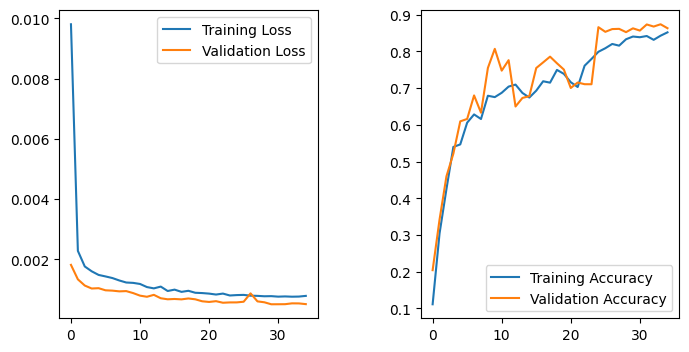

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(history.history["loss"], label="Training Loss")
axes[0].plot(history.history["val_loss"], label="Validation Loss")
axes[1].plot(history.history["accuracy"], label="Training Accuracy")
axes[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.subplots_adjust(wspace=0.4)
axes[0].legend()
axes[1].legend()

In [ ]:
from solution.feature_extraction import FeatureExtraction
from solution.prediction import prepare_test_df

# Extract new data. This is a normal traffic dataset that will be used to calculate threshold value.
fe = FeatureExtraction(["so-ids-2023.04.14", "so-ids-2023.05.03"], 400)
normal_df = fe.parse_logs()
normal_df = fe.preprocess_dataframe(normal_df)

normal_df = prepare_test_df(normal_df, df)
normal_df.to_pickle("resources/normal_df.pkl")

In [145]:
# Calculate the threshold value using the normal traffic data
normal_df = pd.read_pickle("resources/normal_df.pkl")
print(normal_df.shape)

loss = predict(autoencoder, normal_df)
threshold = get_threshold(loss, 99)
print("Precision: ", loss[loss <= threshold].size / len(loss))
print("Threshold: ", threshold)
loss[loss > threshold].size, loss[loss <= threshold].size

(4341, 139)
136/136 [==============================] - 0s 3ms/step
Precision:  0.9921677032941718
Threshold:  0.03612295576403331


0.03612295576403331